In [1]:
# NumPy for numerical computing
import numpy as np
# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
import matplotlib.pyplot as plt
# display plots in the notebook
%matplotlib inline
# Seaborn for easier visualization
import seaborn as sns

In [2]:
data = pd.read_csv('../input/hr-data/HR_comma_sep.csv')

In [3]:
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<span id="drop"></span>
## Data preprocessing

In [4]:
# Unique classes of 'department'
data.Department.unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

<span id="missing-data"></span>
## Handle missing data

In [5]:
# check for missing values
data.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

The data features has no missing values

<span id="engineer-features"></span>

## Engineer features

These roughly translate to 3 **indicator features** we can engineer:

* <code style="color:steelblue">'underperformer'</code> - last_evaluation < 0.6
* <code style="color:steelblue">'unhappy'</code> - satisfaction_level < 0.4
* <code style="color:steelblue">'overachiever'</code> - last_evaluation > 0.8 and satisfaction > 0.7

In [6]:
# Create indicator features
data['underperformer'] = (data.last_evaluation < 0.6).astype(int)
data['unhappy'] = (data.satisfaction_level < 0.4).astype(int)
data['overachiever'] = ((data.last_evaluation > 0.8) & (data.satisfaction_level > 0.7)).astype(int)

In [7]:
# The proportion of observations belonging to each group
data[['underperformer', 'unhappy', 'overachiever']].mean()

underperformer    0.316154
unhappy           0.194346
overachiever      0.186212
dtype: float64

<span id="save-abt"></span>
## Updated Dataset


In [8]:
# Create new dataframe with dummy features
add_columns = data.select_dtypes(include=['object']).columns
dummy_table = pd.get_dummies(data, columns=add_columns)
# Display first 10 rows
pd.set_option('display.max_columns', 50)
dummy_table.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,underperformer,unhappy,overachiever,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0


## Model Training
<span id=training><span>

In [9]:
# Pickle for saving model files
import pickle

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
# Function for splitting training and test set
from sklearn.model_selection import train_test_split
# Function for creating model pipelines
from sklearn.pipeline import make_pipeline
# For standardization
from sklearn.preprocessing import StandardScaler
# Helper for cross-validation
from sklearn.model_selection import GridSearchCV
# Classification metrics (added later)
from sklearn.metrics import roc_curve, auc

#### Split the data

In [10]:
# Create separate object for target variable
y = dummy_table.left

# Create separate object for input features
X = dummy_table.drop('left', axis=1)

In [12]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= 0.2,
                                                    random_state=1234,
                                                    stratify=dummy_table.left)

# Print number of observations in X_train, X_test, y_train, and y_test
print(len(X_train), len(X_test), len(y_train), len(y_test))

11999 3000 11999 3000


<span id="pipelines"></span>
## Build model pipelines

In [42]:
pipeline = make_pipeline(RandomForestClassifier(random_state=123))

Scaling has not been done to keep the model simple, since predictions are done for single input observation. But scaling is required for making a model which can give credible predictions

In [43]:
# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]
}

In [16]:
rf = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=None, 
    min_samples_split=10, 
    class_weight="balanced"
    #min_weight_fraction_leaf=0.02 
    )
model=rf.fit(X_train, y_train)
print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       0.99      0.96      0.97       714

   micro avg       0.99      0.99      0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



<span id="fit-tune"></span>
### Fit and tune models with cross-validation

In [45]:
model = GridSearchCV(pipeline, rf_hyperparameters, cv=10, n_jobs=-1)

model.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'randomforestclassifier__n_estimators': [100, 200], 'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [17]:
# model best score
model.best_score_

AttributeError: 'RandomForestClassifier' object has no attribute 'best_score_'

<span id="evaluate"></span>
## Evaluate metrics

In [18]:
# Classification metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [19]:
pred = model.predict(X_test)

In [20]:
print(confusion_matrix(y_test, pred))

[[2279    7]
 [  29  685]]


In [21]:
pred_prob = model.predict_proba(X_test)

pred_prob = [p[1] for p in pred_prob]

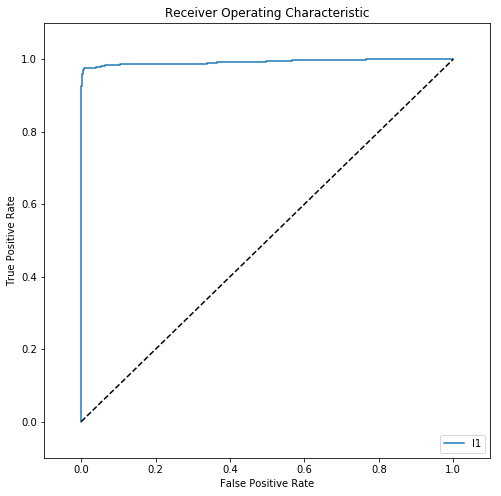

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)

# Initialize figure
plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
# Calculate AUROC
print(auc(fpr, tpr))

0.9924102624426847


In [27]:
# Save winning model as final_model.pkl
with open('final_model.pkl', 'wb') as f:
    pickle.dump(model, f)

#### Reading the pickle file to get the stored model to perform predictions and calculate auc

In [28]:
objects = []
with open('final_model.pkl', 'rb') as f:
    objects.append(pickle.load(f))

In [30]:
pred = objects[0].predict_proba(X_test)
pred = [p[1] for p in pred]

fpr, tpr, threshold = roc_curve(y_test, pred)
print(auc(fpr, tpr)) 

0.9924102624426847


The score matches the previous AUROC score, the model was saved into pickle file correctly and can be used for making predictions